In [1]:
import pandas as pd
import numpy as np
import json

from area import area

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<h2>Load data and prepare data</h2>

In [2]:
df2015raw = pd.read_csv('data/2015_carto_table.csv')

In [ ]:
properties_df_raw = pd.read_csv('data/Property_Valuation_and_Assessment_Data.csv')

In [5]:
properties_df_raw = properties_df_raw[properties_df_raw['YEAR'] == '2015/16']

<h2>Check data properties</h2>

In [6]:
properties_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1096247 entries, 3278495 to 4426254
Data columns (total 39 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   BBLE              1096247 non-null  object 
 1   BORO              1096247 non-null  int64  
 2   BLOCK             1096247 non-null  int64  
 3   LOT               1096247 non-null  int64  
 4   EASEMENT          4587 non-null     object 
 5   OWNER             1076542 non-null  object 
 6   BLDGCL            1096247 non-null  object 
 7   TAXCLASS          1096247 non-null  object 
 8   LTFRONT           1096247 non-null  int64  
 9   LTDEPTH           1096247 non-null  int64  
 10  EXT               353375 non-null   object 
 11  STORIES           1040521 non-null  float64
 12  FULLVAL           1096247 non-null  int64  
 13  AVLAND            1096247 non-null  int64  
 14  AVTOT             1096247 non-null  int64  
 15  EXLAND            1096247 non-null  int64  

In [7]:
df2015raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683702 entries, 0 to 683701
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   health      652087 non-null  object 
 1   spc_latin   652084 non-null  object 
 2   spc_common  652084 non-null  object 
 3   borough     683702 non-null  object 
 4   ntaname     683702 non-null  object 
 5   shape_area  683702 non-null  float64
dtypes: float64(1), object(5)
memory usage: 31.3+ MB


<h2>Inspect properties data </h2>

In [48]:
properties_df_raw= properties_df_raw[['FULLVAL', 'AVLAND', 'AVTOT','Borough','Latitude','Longitude']]
properties_df_raw.dropna(inplace=True)
properties_df_raw.columns = map(str.lower, properties_df_raw.columns)
properties_df_raw = properties_df_raw.applymap(lambda s:s.lower() if type(s) == str else s)
properties_df_raw.rename(columns={'fullval': 'full value', 'avland': 'avg.land value/acre'}, inplace=True)
properties_df = properties_df.applymap(lambda s:s.lower() if type(s))
properties_df.dropna(inplace=True)
properties_df=properties_df[['original market value', 'original assessed value', 'borough', 'latitude', 'longitude']]
properties_df.rename(columns={'original market value': 'market value', 'original assessed value': 'assessed value'}, inplace=True)

<h2>Use carto.com to add neighborhoods names for each tree and property </h2>


Save dataframe to csv files.Save by parts as we then upload it to Carto.com with platform files' size restrictions. We do it to find neighborhood names based on longitude an latitude.

In [ ]:
properties_df_raw[:200000].to_csv(r'data\CleanedPropertiesData1.csv')
properties_df_raw[200000:400000].to_csv(r'data\CleanedPropertiesData2.csv')
properties_df_raw[400000:600000].to_csv(r'data\CleanedPropertiesData3.csv')
properties_df_raw[600000:800000].to_csv(r'data\CleanedPropertiesData4.csv')
properties_df_raw[800000:].to_csv(r'data\CleanedPropertiesData5.csv')

At this point we uploaded everything to Carto.com and received files where each property has a 'ntaname' feature.

In [ ]:
properties_df1 = pd.read_csv('data\cleanedpropertiesdata1.csv')
properties_df2 = pd.read_csv('data\cleanedpropertiesdata2.csv')
properties_df3 = pd.read_csv('data\cleanedpropertiesdata3.csv')
properties_df4 = pd.read_csv('data\cleanedpropertiesdata4.csv')
properties_df5 = pd.read_csv('data\cleanedpropertiesdata5.csv')

In [ ]:
properties_df = properties_df1.append(properties_df2, ignore_index=True).append(properties_df3, ignore_index=True).append(properties_df4, ignore_index=True).append(properties_df5, ignore_index=True)
properties_df = properties_df[['ntaname', 'borough', 'full_value', 'avg_land_value_acre', 'avtot']]
properties_df.rename(columns={'full_value': 'property value', 'avg_land_value_acre': 'avg.land value/acre'}, inplace=True)
properties_df = properties_df.applymap(lambda s:s.lower() if type(s) == str else s)
properties_df['count']= 1
properties_df_grouped = properties_df.groupby(['ntaname','borough']).agg({'count': ['count'], 'avg.land value/acre':['mean'], 'property value':['mean'], 'avtot':['mean']})
properties_df_grouped.to_csv(r'data\GroupedPropertiesData.csv')

<h2>Inspect trees data</h2>

In [5]:
df2015raw.columns = map(str.lower, df2015raw.columns)
df2015raw = df2015raw.applymap(lambda s:s.lower() if type(s) == str else s)

Accorfing to NYC Open Data manual, if data is missing in the "health" column it means the tree is dead

In [172]:
df2015raw['health'].fillna(value = 'dead', inplace = True)
df2015raw.dropna(inplace=True)

In [173]:
health_level_names3 = df2015raw.groupby('health').count()
print(health_level_names3)

        spc_latin  spc_common  borough  ntaname  shape_area
health                                                     
Fair        96490       96490    96490    96490       96490
Good       528781      528781   528781   528781      528781
Poor        26811       26811    26811    26811       26811
dead            2           2        2        2           2


In [176]:
health_level = {'good': 15, 'fair': 10, 'poor': 5, 'dead': 0} 
df2015raw['health'] = [health_level[item] for item in df2015raw['health']] 

Recalculate sq. feet to sq. miles:

In [178]:
df2015raw['shape_area'] = df2015raw['shape_area']/27878400


Group by neighborhoods

In [180]:
df2015raw['count'] = 1
df2015_grouped_by_speices = df2015raw.groupby(['ntaname', 'borough', 'spc_common'], as_index=False).agg({'count': ['count'], 'shape_area':['mean']})

In [181]:
df2015_grouped_by_speices.columns = df2015_grouped_by_speices.columns.get_level_values(0)
df2015_grouped_by_nta = df2015raw.groupby(['ntaname','borough'], as_index=False).agg({'count': ['count'], 'shape_area':['mean'], 'health':['mean']})

In [183]:
df2015_grouped_by_nta.columns = df2015_grouped_by_nta.columns.get_level_values(0)
df2015_grouped_by_nta['trees/sq.mile'] = df2015_grouped_by_nta['count']/df2015_grouped_by_nta['shape_area']
df2015_grouped_by_nta

,ntaname,borough,count,shape_area,health,trees/sq.mile
0,airport,queens,155,8.185520,14.322581,18.935877
1,allerton-pelham gardens,bronx,3609,1.136832,13.941535,3174.612844
2,annadale-huguenot-prince's bay-eltingville,staten island,12538,5.059752,13.418408,2477.987095
3,arden heights,staten island,6729,1.808239,13.910685,3721.299694
4,astoria,queens,4183,1.410967,14.040163,2964.632633
...,...,...,...,...,...,...
192,windsor terrace,brooklyn,2030,0.503676,14.098522,4030.372441
193,woodhaven,queens,3956,1.327208,14.122851,2980.693636
194,woodlawn-wakefield,bronx,3802,1.425433,14.251710,2667.260036
195,woodside,queens,2610,1.013265,13.802682,2575.830528


In [197]:
df2015_grouped_by_nta

,ntaname,borough,count,shape_area,health,trees/sq.mile
0,airport,queens,155,8.185520,14.322581,18.935877
1,allerton-pelham gardens,bronx,3609,1.136832,13.941535,3174.612844
2,annadale-huguenot-prince's bay-eltingville,staten island,12538,5.059752,13.418408,2477.987095
3,arden heights,staten island,6729,1.808239,13.910685,3721.299694
4,astoria,queens,4183,1.410967,14.040163,2964.632633
...,...,...,...,...,...,...
192,windsor terrace,brooklyn,2030,0.503676,14.098522,4030.372441
193,woodhaven,queens,3956,1.327208,14.122851,2980.693636
194,woodlawn-wakefield,bronx,3802,1.425433,14.251710,2667.260036
195,woodside,queens,2610,1.013265,13.802682,2575.830528


In [184]:
final_df = pd.merge(df2015_grouped_by_speices, df2015_grouped_by_nta, on='ntaname', how='outer')
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16338 entries, 0 to 16337
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ntaname        16338 non-null  object 
 1   borough_x      16338 non-null  object 
 2   spc_common     16338 non-null  object 
 3   count_x        16338 non-null  int64  
 4   shape_area_x   16338 non-null  float64
 5   borough_y      16338 non-null  object 
 6   count_y        16338 non-null  int64  
 7   shape_area_y   16338 non-null  float64
 8   health         16338 non-null  float64
 9   trees/sq.mile  16338 non-null  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 1.4+ MB


In [186]:
final_df.drop(columns = ['borough_y', 'shape_area_y'], inplace=True)
final_df.rename(columns={'borough_x': 'borough', 'count_x': 'count', 'count_y': 'total', 'shape_area_x': 'area'}, inplace=True)
final_df.columns

Index(['ntaname', 'borough', 'spc_common', 'count', 'area', 'total', 'health',
       'trees/sq.mile'],
      dtype='object')

In [187]:
final_df['speices %'] = final_df['count']/final_df['total']*100
final_df['trees/sq.mile'] = final_df['total']/final_df['area']
final_df.head(20)

,ntaname,borough,spc_common,count,area,total,health,trees/sq.mile,speices %
0,airport,queens,american hornbeam,5,8.18552,155,14.322581,18.935877,3.225806
1,airport,queens,amur maple,2,8.18552,155,14.322581,18.935877,1.290323
2,airport,queens,black locust,8,8.18552,155,14.322581,18.935877,5.161290
3,airport,queens,callery pear,9,8.18552,155,14.322581,18.935877,5.806452
4,airport,queens,cherry,3,8.18552,155,14.322581,18.935877,1.935484
5,airport,queens,crab apple,1,8.18552,155,14.322581,18.935877,0.645161
6,airport,queens,dawn redwood,1,8.18552,155,14.322581,18.935877,0.645161
7,airport,queens,english oak,2,8.18552,155,14.322581,18.935877,1.290323
8,airport,queens,ginkgo,1,8.18552,155,14.322581,18.935877,0.645161
9,airport,queens,golden raintree,3,8.18552,155,14.322581,18.935877,1.935484


In [188]:
for_species = final_df.groupby(['ntaname', 'borough', 'spc_common']).mean()
for_species.head(20)

count     area  total     health  \
ntaname borough spc_common                                              
airport queens  american hornbeam      5.0  8.18552  155.0  14.322581   
                amur maple             2.0  8.18552  155.0  14.322581   
                black locust           8.0  8.18552  155.0  14.322581   
                callery pear           9.0  8.18552  155.0  14.322581   
                cherry                 3.0  8.18552  155.0  14.322581   
                crab apple             1.0  8.18552  155.0  14.322581   
                dawn redwood           1.0  8.18552  155.0  14.322581   
                english oak            2.0  8.18552  155.0  14.322581   
                ginkgo                 1.0  8.18552  155.0  14.322581   
                golden raintree        3.0  8.18552  155.0  14.322581   
                hawthorn               2.0  8.18552  155.0  14.322581   
                honeylocust           50.0  8.18552  155.0  14.322581   
                japanese tree lilac    1.0  8.18552  155.0  14.322581   
                japanese zelkova       3.0  8.18552  155.0  14.322581   
                littleleaf linden      2.0  8.18552  155.0  14.322581   
                london planetree       2.0  8.18552  155.0  14.322581   
                mulberry               2.0  8.18552  155.0  14.322581   
                northern red oak       3.0  8.18552  155.0  14.322581   
                norway maple           1.0  8.18552  155.0  14.322581   
                oklahoma redbud        1.0  8.18552  155.0  14.322581   

                                     trees/sq.mile  speices %  
ntaname borough spc_common                                     
airport queens  american hornbeam        18.935877   3.225806  
                amur maple               18.935877   1.290323  
                black locust             18.935877   5.161290  
                callery pear             18.935877   5.806452  
                cherry                   18.935877   1.935484  
                crab apple               18.935877   0.645161  
                dawn redwood             18.935877   0.645161  
                english oak              18.935877   1.290323  
                ginkgo                   18.935877   0.645161  
                golden raintree          18.935877   1.935484  
                hawthorn                 18.935877   1.290323  
                honeylocust              18.935877  32.258065  
                japanese tree lilac      18.935877   0.645161  
                japanese zelkova         18.935877   1.935484  
                littleleaf linden        18.935877   1.290323  
                london planetree         18.935877   1.290323  
                mulberry                 18.935877   1.290323  
                northern red oak         18.935877   1.935484  
                norway maple             18.935877   0.645161  
                oklahoma redbud          18.935877   0.645161

In [42]:
for_species = pd.read_csv('data/GroupedTreesDataSpecies.csv')

In [43]:
for_species.head()

,ntaname,borough,spc_common,count,area,total,spc_per
0,airport,queens,american hornbeam,5,8.18552,168.0,2.976190
1,airport,queens,amur maple,2,8.18552,168.0,1.190476
2,airport,queens,black locust,8,8.18552,168.0,4.761905
3,airport,queens,callery pear,9,8.18552,168.0,5.357143
4,airport,queens,cherry,3,8.18552,168.0,1.785714


In [44]:
grouped = for_species[(for_species['ntaname']=='airport') | (for_species['ntaname']=='astoria')].groupby(['spc_common']).sum().sort_values('count', ascending=False)
total = grouped['count'].sum()
grouped['percent'] = grouped['count']/total*100

In [45]:
grouped.reset_index(inplace = True)
grouped = grouped.append({'spc_common': 'other', 'count':total-grouped['count'][:5].sum(), 'percent': 100 - grouped['percent'][:5].sum()}, ignore_index=True)
grouped = grouped.sort_values('percent', ascending=False)


In [46]:
grouped.head(6)

,spc_common,count,area,total,spc_per,percent
94,other,2447,NaN,NaN,NaN,56.408483
0,pin oak,541,9.596488,4556.0,18.626015,12.471185
1,london planetree,468,9.596488,4556.0,11.810349,10.788382
2,honeylocust,373,9.596488,4556.0,37.122889,8.598432
3,callery pear,270,9.596488,4556.0,11.305183,6.224066
4,littleleaf linden,239,9.596488,4556.0,6.591570,5.509451


In [ ]:
for_species.to_csv(r'data\GroupedTreesDataSpecies.csv')
df2015_grouped_by_nta.to_csv(r'data\GroupedTreesData.csv')

<h1>Merge properties and trees sets</h1>

Read data

In [6]:
properties_df = pd.read_csv('data\GroupedPropertiesData.csv')
trees_df = pd.read_csv('data\GroupedTreesData.csv')
species_df = pd.read_csv('data\GroupedTreesDataSpecies.csv')

FileNotFoundError: [Errno 2] File data\GroupedPropertiesData.csv does not exist: 'data\\GroupedPropertiesData.csv'

Inspect data

In [9]:
print(properties_df.columns)
print(trees_df.columns)
properties_df['avg.land value/acre'] = properties_df['avg.land value/acre']/1000
properties_df['property value'] = properties_df['property value']/1000
properties_df.rename(columns={'avg.land value/acre':'avg.landprice_thous$/acre', 'property value':'avg.propvalue_thous$/acre'}, inplace = True)

Index(['ntaname', 'borough', 'count', 'avg.land value/acre', 'property value',
       'avtot'],
      dtype='object')
Index(['Unnamed: 0', 'ntaname', 'borough', 'count', 'shape_area', 'health',
       'trees/sq.mile'],
      dtype='object')


Merge data

In [10]:
df = pd.merge(trees_df, properties_df, on='ntaname', how='outer')
df.columns

Index(['Unnamed: 0', 'ntaname', 'borough_x', 'count_x', 'shape_area', 'health',
       'trees/sq.mile', 'borough_y', 'count_y', 'avg.landprice_thous$/acre',
       'avg.propvalue_thous$/acre', 'avtot'],
      dtype='object')

In [11]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [12]:
df.rename(columns={'borough_x': 'borough', 'shape_area': 'area', 'count_x': '#trees', 'count_y':'#properties'}, inplace= True)
df.dropna(inplace=True)

In [13]:
df.head()

,ntaname,borough,#trees,area,health,trees/sq.mile,borough_y,#properties,avg.landprice_thous$/acre,avg.propvalue_thous$/acre,avtot
0,airport,queens,155.0,8.185520,14.322581,18.935877,queens,2,1995.03350,4694.50000,2000580.00
1,allerton-pelham gardens,bronx,3609.0,1.136832,13.941535,3174.612844,bronx,5359,18.23883,512.23843,59657.46
2,annadale-huguenot-prince's bay-eltingville,staten island,12538.0,5.059752,13.418408,2477.987095,staten island,8389,19.10656,619.13935,55649.67
3,arden heights,staten island,6729.0,1.808239,13.910685,3721.299694,staten island,7702,9.65568,448.18923,33080.58
4,astoria,queens,4183.0,1.410967,14.040163,2964.632633,queens,8147,42.31469,895.98350,178549.60


In [24]:
df.to_csv('data\MergedTreesPropertiesData.csv')

<h2>Remove outliers</h2>

In [13]:
from scipy import stats

dfN = pd.read_csv('data\MergedTreesPropertiesData.csv')
dfN.drop(columns={'Unnamed: 0', '#trees', 'borough_y', '#properties','avtot'}, inplace = True)

dfN = dfN[(np.abs(stats.zscore(dfN['health'])) <= 4)] # result: no outliers
dfN = dfN[(np.abs(stats.zscore(dfN['trees/sq.mile'])) <= 4)]
dfN = dfN[(np.abs(stats.zscore(dfN['avg.landprice_thous$/acre'])) <= 4)]
dfN = dfN[(np.abs(stats.zscore(dfN['properties/sq.mile'])) <= 4)]
dfN = dfN[dfN['avg.landprice_thous$/acre']>0]

In [14]:
dfN.describe()

,area,health,trees/sq.mile,avg.landprice_thous$/acre,avg.propvalue_thous$/acre,properties/sq.mile
count,190.000000,190.000000,190.000000,190.000000,190.000000,190.000000
mean,1.559053,13.813053,2684.640211,155.215789,1378.768368,4540.446474
std,1.616576,0.413918,948.106545,652.815931,2357.728997,2736.711824
min,0.230000,12.240000,0.850000,9.660000,379.150000,0.240000
25%,0.712500,13.605000,2189.205000,23.432500,563.217500,2729.862500
50%,1.170000,13.880000,2716.540000,35.395000,774.370000,4133.000000
75%,1.787500,14.107500,3303.572500,61.227500,1119.735000,5758.895000
max,11.760000,15.000000,5668.670000,6010.770000,19352.000000,15765.300000


9 neighborhoods were removed from the dataframe as their z-score of one of the columns was in [-3,3] interval. 

In [15]:
dfN.to_csv('data\MergedTreesPropertiesDataNoOutliers.csv')

<h1>Borough-level information</h1>

In [16]:
boro_df = pd.read_csv('data\MergedTreesPropertiesDataNoOutliers.csv')

In [17]:
boro_df.drop(columns={'Unnamed: 0'}, inplace = True)

In [18]:
boro_df

,ntaname,borough,area,health,trees/sq.mile,avg.landprice_thous$/acre,avg.propvalue_thous$/acre,properties/sq.mile
0,airport,queens,8.19,14.32,18.94,1995.03,4694.50,0.24
1,allerton-pelham gardens,bronx,1.14,13.94,3174.61,18.24,512.24,4713.98
2,annadale-huguenot-prince's bay-eltingville,staten island,5.06,13.42,2477.99,19.11,619.14,1657.99
3,arden heights,staten island,1.81,13.91,3721.30,9.66,448.19,4259.39
4,astoria,queens,1.41,14.04,2964.63,42.31,895.98,5774.05
...,...,...,...,...,...,...,...,...
185,windsor terrace,brooklyn,0.50,14.10,4030.37,20.11,1012.04,6815.90
186,woodhaven,queens,1.33,14.12,2980.69,18.38,497.90,6812.80
187,woodlawn-wakefield,bronx,1.43,14.25,2667.26,16.15,457.65,4944.46
188,woodside,queens,1.01,13.80,2575.83,42.71,742.72,4756.90


In [19]:
#boro_df_no_outliers = boro_df[(boro_df['avg.landprice_thous$/acre']<1000) & (boro_df['avg.landprice_thous$/acre']>0) ]
boro_df = boro_df.groupby(['borough']).agg({'area':['sum'],'health': ['mean'], 'trees/sq.mile':['mean'], 'avg.landprice_thous$/acre':['mean'], 'properties/sq.mile':['mean']})
boro_df.columns = boro_df.columns.get_level_values(0)

boro_df.head()

,area,health,trees/sq.mile,avg.landprice_thous$/acre,properties/sq.mile
borough,,,,,
bronx,34.29,13.886667,2582.143056,58.444444,2665.613056
brooklyn,69.47,13.874510,2844.993137,154.762157,5497.278235
manhattan,18.79,13.418077,3210.450385,257.268077,7584.695000
queens,116.28,13.855085,2545.812881,209.636949,4061.352373
staten island,57.39,13.924444,2130.842778,24.254444,2752.206111


In [20]:
boro_df.to_csv(r'data\MergedTreesPropertiesDataBoro.csv')

<h1>Is there correlation?</h1>

In [21]:
dfB = pd.read_csv('data\MergedTreesPropertiesDataBoro.csv')
dfN = pd.read_csv('data\MergedTreesPropertiesDataNoOutliers.csv')
dfN.drop(columns={'Unnamed: 0', 'avg.propvalue_thous$/acre'}, inplace=True)


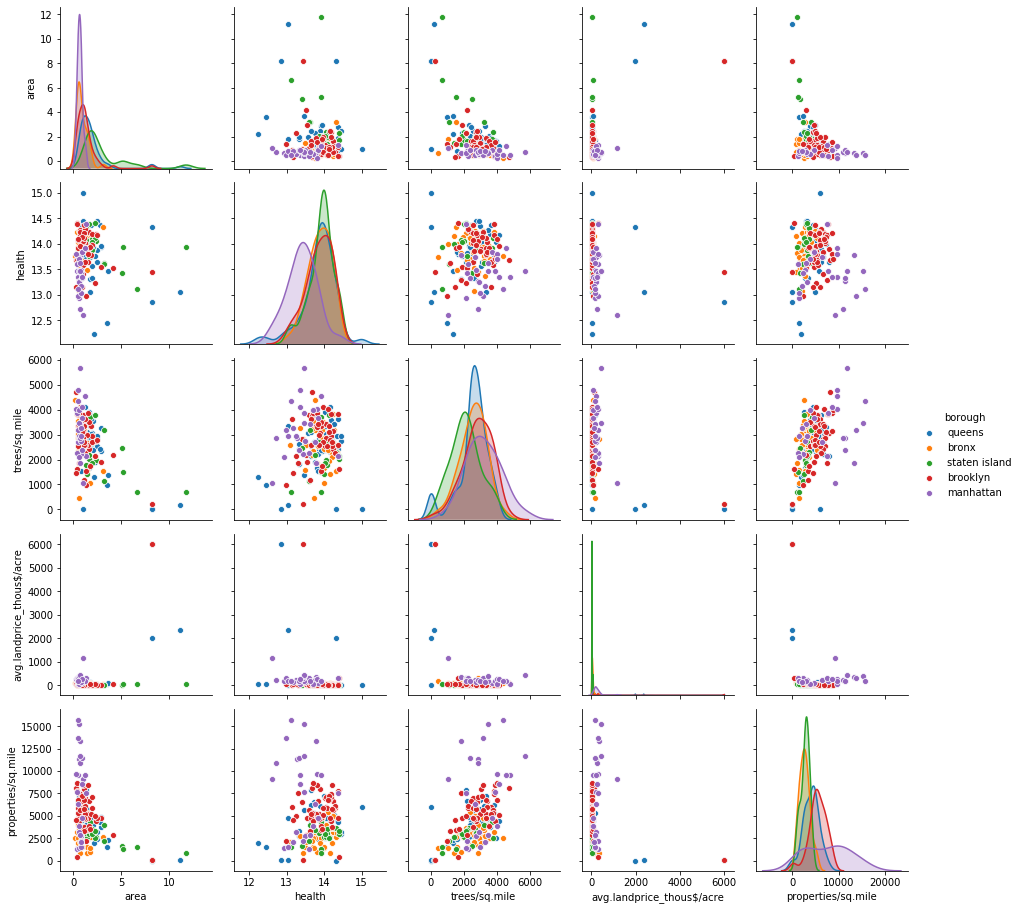

In [22]:
sns.pairplot(dfN, hue = 'borough')

C:\Users\mskac\Anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


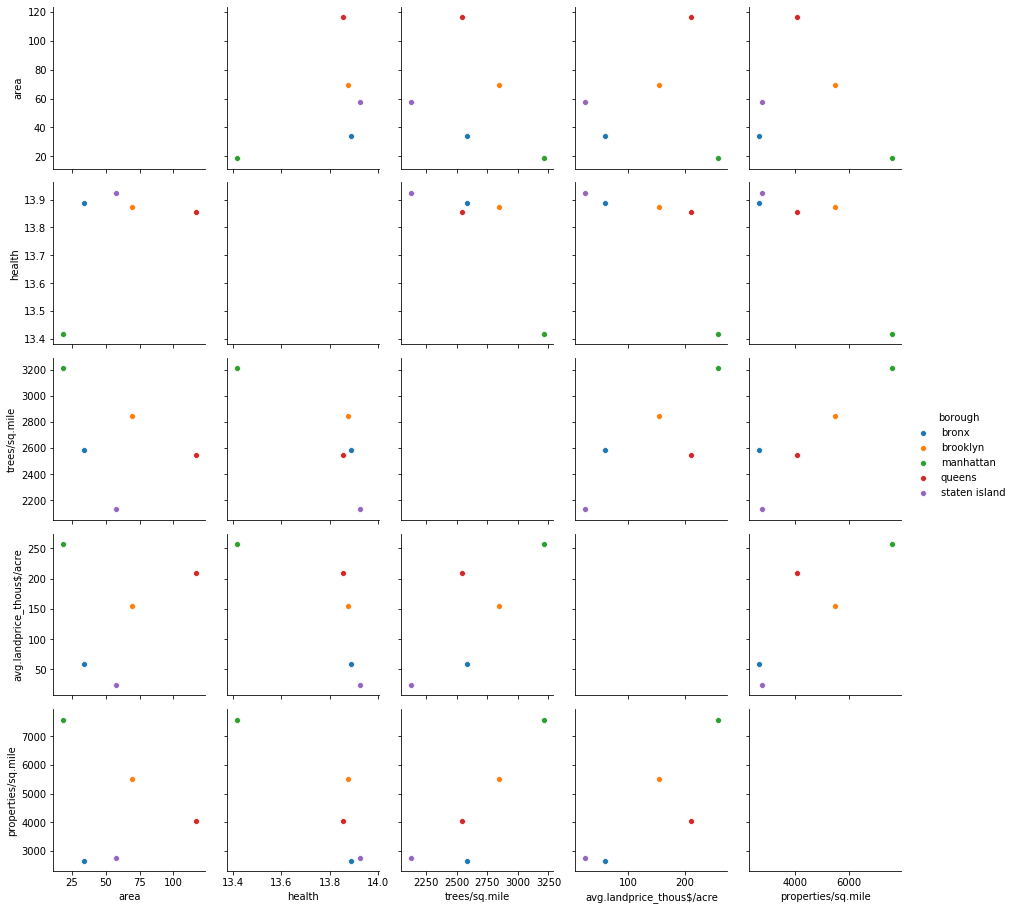

In [23]:
sns.pairplot(dfB, hue = 'borough')

In [25]:
dfB.corr(method ='pearson') 

,area,health,trees/sq.mile,avg.landprice_thous$/acre,properties/sq.mile
area,1.000000,0.537578,-0.400748,0.110191,-0.292042
health,0.537578,1.000000,-0.819839,-0.738722,-0.863664
trees/sq.mile,-0.400748,-0.819839,1.000000,0.807074,0.908938
avg.landprice_thous$/acre,0.110191,-0.738722,0.807074,1.000000,0.855397
properties/sq.mile,-0.292042,-0.863664,0.908938,0.855397,1.000000


In [26]:
dfN.corr(method ='pearson') 

,area,health,trees/sq.mile,avg.landprice_thous$/acre,properties/sq.mile
area,1.000000,-0.110751,-0.532093,0.549059,-0.369445
health,-0.110751,1.000000,0.091497,-0.231319,-0.053447
trees/sq.mile,-0.532093,0.091497,1.000000,-0.356549,0.471938
avg.landprice_thous$/acre,0.549059,-0.231319,-0.356549,1.000000,-0.162541
properties/sq.mile,-0.369445,-0.053447,0.471938,-0.162541,1.000000


In [27]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
y = scaler.fit_transform(np.array(dfN['trees/sq.mile']).reshape(-1,1))  
scaler = StandardScaler() 
X = scaler.fit_transform(np.array(dfN['properties/sq.mile']).reshape(-1,1))  
X2 = sm.add_constant(X) 
est = sm.OLS(y, X2) 

print(est.fit().f_pvalue)

6.26252747665699e-12


We can notice that there is a slight correlation between number of trees per sq.mile and number of properties per sq.mile

In [28]:
dfN[dfN['avg.landprice_thous$/acre']>1100].index

Int64Index([0, 108, 131, 132, 133], dtype='int64')

In [112]:
dfN_no_outliers=dfN.drop(dfN[dfN['avg.landprice_thous$/acre']>1100].index)

In [115]:
dfN_no_manhattan = dfN_no_outliers.drop(dfN_no_outliers[dfN_no_outliers['borough']=='manhattan'].index)

In [118]:
dfN_no_manhattan[dfN_no_manhattan['avg.landprice_thous$/acre']>100]

,ntaname,borough,area,health,trees/sq.mile,avg.landprice_thous$/acre,properties/sq.mile
22,brooklyn heights-cobble hill,brooklyn,0.36,13.69,4705.22,107.08,8106.38
36,co-op city,bronx,1.43,14.16,1420.74,111.56,876.24
86,hunts point,bronx,1.78,13.82,1846.04,103.64,979.36
87,jackson heights,queens,1.72,13.74,3802.80,138.31,5283.61
101,marble hill-inwood,bronx,0.64,13.74,454.35,157.76,1352.05
160,starrett city,brooklyn,0.42,14.40,1639.21,287.46,425.42
174,west concourse,bronx,0.70,13.44,2846.85,322.25,799.82


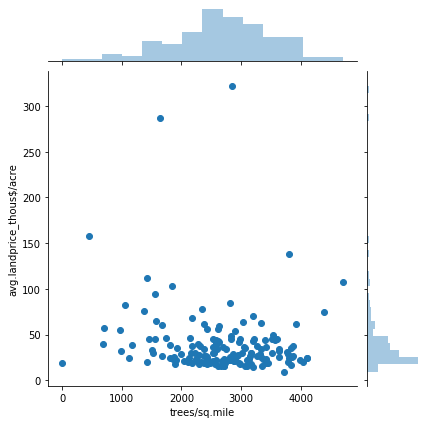

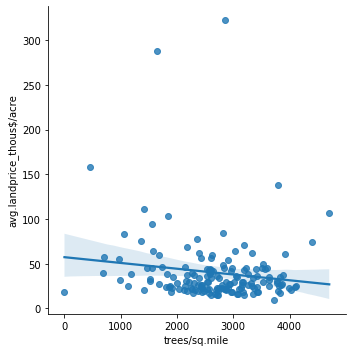

In [116]:
sns.jointplot(x='trees/sq.mile', y = 'avg.landprice_thous$/acre', data=dfN_no_manhattan)
sns.lmplot(x='trees/sq.mile', y='avg.landprice_thous$/acre', data=dfN_no_manhattan)

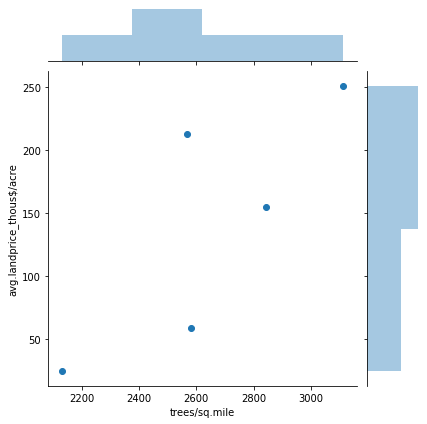

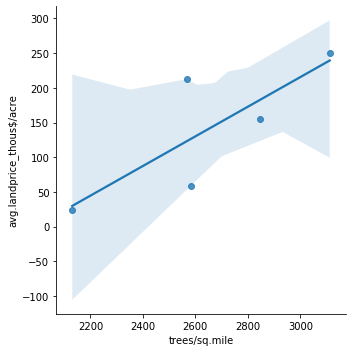

In [103]:
sns.jointplot(x='trees/sq.mile', y = 'avg.landprice_thous$/acre', data=dfB)
sns.lmplot(x='trees/sq.mile', y='avg.landprice_thous$/acre', data=dfB)